In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("/content/drive/MyDrive/cleaned_taxi.csv")


In [4]:
X = df[['pickup_hour', 'weekday_num', 'month', 'pickup_location_id', 'dropoff_location_id', 'trip_distance','trip_duration_seconds','rate_code']]
Y = df['speed']


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Define input shape (number of features)
input_shape = X_train.shape[1]

# Define LSTM model with additional layers
model_lstm = tf.keras.Sequential([
    Input(shape=(input_shape, 1)),  # Input shape: (number of features, 1) for LSTM
    LSTM(64, activation='relu', return_sequences=True),  # LSTM layer with 64 units and return sequences
    Dropout(0.2),  # Dropout layer for regularization
    LSTM(64, activation='relu'),  # Second LSTM layer with 64 units
    Dropout(0.2),  # Dropout layer for regularization
    Dense(32, activation='relu'),  # Dense layer with 32 units and ReLU activation
    Dense(1, activation='linear')  # Output layer with 1 neuron (for regression)
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 8, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Layer

class RBMLayer(Layer):
    def __init__(self, n_components, activation='sigmoid', **kwargs):
        super(RBMLayer, self).__init__(**kwargs)
        self.n_components = n_components
        self.activation = activation
        self.rbm = tf.keras.layers.Dense(n_components, activation=activation)

    def call(self, inputs):
        return self.rbm(inputs)

# Define the input shape
input_shape = X_train.shape[1]

# Initialize the DBN model
model_dbn = Sequential()

# Add the first RBM layer
model_dbn.add(RBMLayer(n_components=64))
model_dbn.add(Dense(64, activation='relu'))
model_dbn.add(Dropout(0.2))

# Add the second RBM layer
model_dbn.add(RBMLayer(n_components=32))
model_dbn.add(Dense(32, activation='relu'))
model_dbn.add(Dropout(0.2))

# Add the output layer
model_dbn.add(Dense(1, activation='linear'))

# Compile the model
model_dbn.compile(optimizer='adam', loss='mean_squared_error')

# Build the model by calling the build() method or passing a batch of data
# model_dbn.build(input_shape)  # Uncomment this line if you want to explicitly build the model
# OR
model_dbn.predict(X_train[:1])  # Pass a batch of data through the model to build it implicitly

# Display the model summary
model_dbn.summary()



1/1 [==============================] - 0s 390ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbm_layer (RBMLayer)        (None, 64)                576       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 rbm_layer_1 (RBMLayer)      (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 

In [8]:
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model

# Define the input layer for the Sequential model (LSTM)
lstm_input = Input(shape=(input_shape, 1))

# Get the output of the Sequential model (LSTM)
lstm_output = model_lstm(lstm_input)

# Define the input layer for the Sequential_4 model (DBN)
dbn_input = Input(shape=(input_shape,))

# Get the output of the Sequential_4 model (DBN)
dbn_output = model_dbn(dbn_input)

# Concatenate the outputs of both models
combined_output = Concatenate()([lstm_output, dbn_output])

# Add a dense layer for final prediction
combined_output = Dense(1, activation='linear')(combined_output)

# Define the combined model
combined_model = Model(inputs=[lstm_input, dbn_input], outputs=combined_output)

# Compile the combined model
combined_model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
combined_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8, 1)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, 1)                    52033     ['input_2[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 1)                    7905      ['input_3[0][0]']             
                                                                                              

In [9]:
# Define X_train_lstm and X_test_lstm
X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define X_train_dbn and X_test_dbn
X_train_dbn = X_train.values
X_test_dbn = X_test.values


In [10]:
# Train the combined model
combined_model.fit([X_train_lstm, X_train_dbn], Y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the combined model
loss = combined_model.evaluate([X_test_lstm, X_test_dbn], Y_test)
print("Test Loss:", loss)


Epoch 1/10
49405/49405 [==============================] - 1020s 21ms/step - loss: 3.4101 - val_loss: 9.2338
Epoch 2/10
49405/49405 [==============================] - 1124s 23ms/step - loss: 0.5314 - val_loss: 8.5921
Epoch 3/10
49405/49405 [==============================] - 1037s 21ms/step - loss: 0.5837 - val_loss: 8.0818
Epoch 4/10
49405/49405 [==============================] - 1042s 21ms/step - loss: 0.3653 - val_loss: 9.3206
Epoch 5/10
49405/49405 [==============================] - 965s 20ms/step - loss: 0.6199 - val_loss: 7.3615
Epoch 6/10
49405/49405 [==============================] - 916s 19ms/step - loss: 0.6022 - val_loss: 6.8046
Epoch 7/10
49405/49405 [==============================] - 917s 19ms/step - loss: 0.3896 - val_loss: 7.4238
Epoch 8/10
49405/49405 [==============================] - 926s 19ms/step - loss: 0.9325 - val_loss: 8.3697
Epoch 9/10
49405/49405 [==============================] - 924s 19ms/step - loss: 0.8028 - val_loss: 4.1816
Epoch 10/10
52934/52934 [========

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score

# Make predictions
Y_pred = combined_model.predict([X_test_lstm, X_test_dbn])

# Calculate Mean Squared Error
mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)





52934/52934 [==============================] - 273s 5ms/step
Mean Squared Error (MSE): 7.775486577302697
Root Mean Squared Error (RMSE): 2.788455948603581


AttributeError: 'Functional' object has no attribute 'score'

In [14]:
# Make predictions
#Y_pred = combined_model.predict([X_test_lstm, X_test_dbn])

# Calculate R-squared Score
r2_score_value = r2_score(Y_test, Y_pred)
print("R-squared (R2) Score:", r2_score_value)

R-squared (R2) Score: 0.9038905444382805


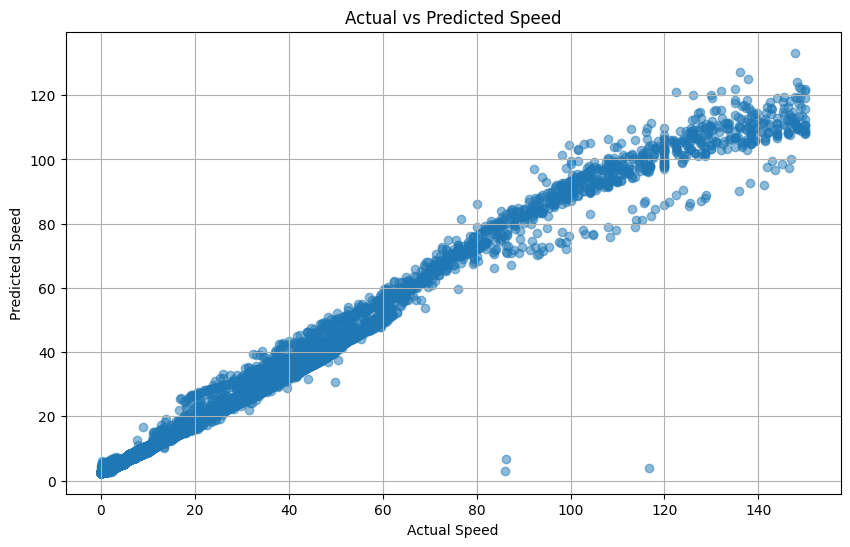

In [17]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Actual vs Predicted Speed')
plt.grid(True)
plt.show()